# flats-in-cracow machine learning

## Imports

In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib

from matplotlib.ticker import MaxNLocator

from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error)
from pylab import rcParams

## Setup

In [73]:
rcParams['figure.figsize'] = (4, 4)

In [74]:
pd.options.display.float_format = "{:,.2f}".format

## Data loading

In [75]:
path = '../flats-data/00_data.csv'

In [76]:
data = pd.read_csv(path, lineterminator='\n')

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2807 entries, 0 to 2806
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   District   2807 non-null   object
 1   Amount     2807 non-null   int64 
 2   Seller     2807 non-null   object
 3   Area       2807 non-null   int64 
 4   Rooms      2807 non-null   int64 
 5   Bathrooms  2807 non-null   int64 
 6   Parking    2807 non-null   object
 7   Garden     2807 non-null   bool  
 8   Balcony    2807 non-null   bool  
 9   Terrace    2807 non-null   bool  
 10  Lift       2807 non-null   bool  
 11  New        2807 non-null   bool  
 12  Estate     2807 non-null   bool  
 13  Townhouse  2807 non-null   bool  
 14  Apartment  2807 non-null   bool  
 15  Land       2807 non-null   bool  
 16  Studio     2807 non-null   bool  
dtypes: bool(10), int64(4), object(3)
memory usage: 181.0+ KB


In [78]:
data.head()

,District,Amount,Seller,Area,Rooms,Bathrooms,Parking,Garden,Balcony,Terrace,Lift,New,Estate,Townhouse,Apartment,Land,Studio
0,dębniki,990000,realtor,93,4,2,street,False,False,False,False,False,False,False,False,False,False
1,prądnik biały,401430,realtor,41,2,1,none,False,True,True,True,True,False,False,False,False,False
2,krowodrza,520000,realtor,55,3,1,street,False,False,False,False,False,False,False,False,False,False
3,bieżanów,287387,realtor,38,2,1,garage,False,True,False,False,False,False,False,False,False,False
4,mistrzejowice,532928,realtor,61,2,1,none,False,False,False,False,True,True,False,False,False,False


## Feature engineering

The next step is to engineer features. We add columns describing the `Total Rooms` in the property, ratio of `Area to Rooms` and so on.

In [79]:
data['Log Area'] = np.round(np.log(data['Area']), 2)
data['Bool Sum'] = data.select_dtypes(bool).sum(axis=1)
# Avoid division by zero
data['Area to Bool Sum'] = round(data['Area'] / (data.select_dtypes(bool).sum(axis=1) + 1), 2)
data['Rooms to Bool Sum'] = round(data['Rooms'] / (data.select_dtypes(bool).sum(axis=1) + 1), 2)
data['Rooms to Bathrooms' ] = round(data['Rooms'] / data['Bathrooms'], 2)
data['Total Rooms'] = round(data['Rooms'] + data['Bathrooms'], 2)
data['Area to Rooms'] = round(data['Area'] / data['Rooms'], 2)
data['Area to Bathrooms'] = round(data['Area'] / data['Rooms'], 2)
data['Area to Total Rooms'] = round(data['Area'] / data['Total Rooms'], 2)

## Data split

We decide to use 80% of the data to train the model and 20% to check performance.
We make sure to remove the `Amount` column from the training data since this is our target.

In [80]:
X = data.drop(['Amount'], axis=1)
y = data['Amount']

split = train_test_split(X, y, train_size=.8,
                               random_state=123)

X_train, X_test, y_train, y_test = split

## Baseline model

For comparison purposes we create a model to give base predictions.

In [81]:
reg_dummy = DummyRegressor()

## Model

Then we create the actual model.

In [82]:
reg = GradientBoostingRegressor(random_state=123)

## One Hot Encoding

We apply one hot encoding to categorical features and use the `ColumnTransformer` parameter `passthrough` to allow the rest of the columns to remain unchanged.

In [83]:
categorical = list(data.select_dtypes('object').columns)    

categorical_transformer = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', categorical_transformer, categorical)
    ],
    remainder='passthrough'
)

## Pipelines

In [84]:
mdl = Pipeline(steps = [('preprocessor', preprocessor),
                        ('regressor', reg)])

dum = Pipeline(steps = [('preprocessor', preprocessor),
                        ('regressor', reg_dummy)])

## Parameter tuning

In [85]:
param_grid = {"regressor__max_depth": [5], 
              "regressor__n_estimators": [100],
              "regressor__min_samples_split": [2],
              "regressor__min_samples_leaf": [2],
              "regressor__max_features": ['auto']}

gs = GridSearchCV(estimator=mdl, 
                  param_grid=param_grid,
                  cv=2,
                  n_jobs=8,
                  verbose=2)

## Training

In [86]:
dum.fit(X_train, y_train)
gs.fit(X_train, y_train)
mdl = gs.best_estimator_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s finished


## Model performance

We obtain predictions for the testing set and compare `RMSE`, `MAE` and `MSLE` scores of our models.

In [87]:
y_pred_dum = dum.predict(X_test)
y_pred = mdl.predict(X_test)

### Dummy

In [88]:
dum_rmse = mean_squared_error(y_pred=y_pred_dum, y_true=y_test, squared=False)
dum_mae = mean_absolute_error(y_pred=y_pred_dum, y_true=y_test)
dum_msle = mean_squared_log_error(y_pred=y_pred_dum, y_true=y_test)

print(f'Dummy model:')
print(f'RMSE: {dum_rmse:10.2f}')
print(f'MAE:  {dum_mae:10.2f}')
print(f'MSLE: {dum_msle:10.2f}')

Dummy model:
RMSE:  175971.98
MAE:   132031.49
MSLE:       0.09


### Actual

In [89]:
rmse = mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
msle = mean_squared_log_error(y_pred=y_pred, y_true=y_test)

print('Actual model')
print(f'RMSE: {rmse:10.2f}')
print(f'MAE:  {mae:10.2f}')
print(f'MSLE: {msle:10.2f}')

Actual model
RMSE:  107066.66
MAE:    70773.81
MSLE:       0.03


### Comparison

We are happy to see that the `GradientBoostingRegressor` outperfomed the `DummyRegressor` significantly.
In terms of percentages the improvements are:

In [90]:
scores = [[dum_rmse, dum_mae, dum_msle],
          [rmse, mae, msle]]

scores = pd.DataFrame(scores, 
                      index=['Dummy', 'Model'], 
                      columns=['MSE', 'MAE', 'MSLE'])

scores = scores.transpose()
scores['Improvement (%)'] = np.round((scores['Model'] / scores['Dummy'] - 1) * 100, 2)

scores

,Dummy,Model,Improvement (%)
MSE,"175,971.98","107,066.66",-39.16
MAE,"132,031.49","70,773.81",-46.40
MSLE,0.09,0.03,-65.84


## Visualizations 

We produce a couple of plots the visually inspect the performance of our model.
We use the test data set with the predicted `Amount` to produce the plots.

In [91]:
cols = ['Amount', 'Predicted Amount', 
        'District', 'Area', 'Total Rooms']

X_pred = X_test.copy()
X_pred.loc[:, 'Amount'] = y
X_pred.loc[:, 'Predicted Amount'] = y_pred
X_pred = X_pred.loc[:, cols]

X_pred.head()

,Amount,Predicted Amount,District,Area,Total Rooms
2129,389000,"379,495.95",nowa huta,47,4
993,399000,"450,377.48",podgórze,50,3
1757,850000,"895,376.98",krowodrza,83,4
310,430136,"474,245.77",bieżanów,62,5
1050,779000,"718,975.45",krowodrza,95,6


On our first visual it can be seen that there exists a fairly linear relationship between the `Predicted Amount` and the `Area` of the property.

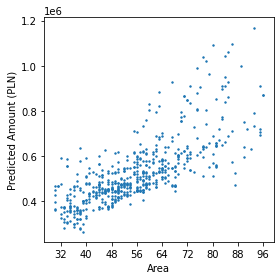

In [104]:
plt.scatter(X_pred['Area'], X_pred['Predicted Amount'], s=2)
plt.xlabel('Area')
plt.ylabel('Predicted Amount (PLN)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig('img/area_vs_amount.png')
plt.show()

On the second visual it can bee seen, as expected the more `Total Rooms` in a `Property` the more it should cost.

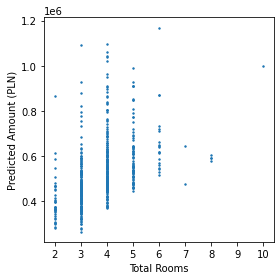

In [105]:
plt.scatter(X_pred['Total Rooms'], X_pred['Predicted Amount'], s=2)
plt.xlabel('Total Rooms')
plt.ylabel('Predicted Amount (PLN)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

Next we want to check if the model distinguishes between districts. We group the data by `District` and calculate the mean of the predictions with the group. We produce a bar chart sorted from highest average to lowest. Clearly the model distinguishes between district that are near the city center (`stare miasto`, `zwierzyniec`) and those further away (`łagiewniki`, `bieżanów`).

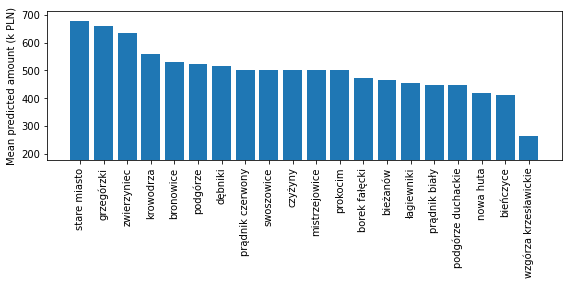

In [94]:
width = 1600
height = width/2
dpi = 200

X_grp = X_pred[['District', 'Predicted Amount']]
X_grp = X_grp.groupby('District', as_index=False).mean()
X_grp = X_grp.sort_values('Predicted Amount', ascending=False)

plt.figure(figsize=(width/dpi, height/dpi))

plt.bar(X_grp['District'], X_grp['Predicted Amount'] / 1000)

plt.ylabel('Mean predicted amount (k PLN)')
plt.ylim(X_grp['Predicted Amount'].min() * 0.67 / 1000, None)
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('img/district_vs_avg_amount.png')
plt.show()

## Getting predictions

Next we would like see how the model handles sets of arbitrary parameters. We write a function to transform inputs to desired format and obtain prediction from the model.

In [95]:
def get_pred(district,
             seller,
             area,
             rooms,
             bathrooms,
             parking,
             garden,
             balcony,
             terrace,
             lift,
             new,
             estate,
             townhouse,
             apartment,
             land,
             studio):

    columns = ['District',
               'Seller',
               'Area',
               'Rooms',
               'Bathrooms',
               'Parking',
               'Garden',
               'Balcony',
               'Terrace',
               'Lift',
               'New',
               'Estate',
               'Townhouse',
               'Apartment',
               'Land',
               'Studio',
               'Log Area',
               'Bool Sum',
               'Area to Bool Sum',
               'Rooms to Bool Sum',
               'Rooms to Bathrooms',
               'Total Rooms',
               'Area to Rooms',
               'Area to Bathrooms',
               'Area to Total Rooms']
        
    log_area = np.log(area)

    all_bools = [garden,
                 balcony,
                 terrace,
                 lift,
                 new,
                 estate,
                 townhouse,
                 apartment,
                 land,
                 studio]
    
    bool_sum = sum(all_bools)
    area_to_bool_sum = area / (bool_sum + 1)
    rooms_to_bool_sum = rooms / (bool_sum + 1)    
    rooms_to_bathrooms = rooms / bathrooms        
    total_rooms = rooms + bathrooms
    area_to_rooms = area / total_rooms
    area_to_bathrooms = area / bathrooms
    area_to_total_rooms = area / total_rooms
    
    x = [district,
         seller,
         area,
         rooms,
         bathrooms,
         parking,
         garden,
         balcony,
         terrace,
         lift,
         new,
         estate,
         townhouse,
         apartment,
         land,
         studio,
         log_area,
         bool_sum,
         area_to_bool_sum,
         rooms_to_bool_sum,
         rooms_to_bathrooms,
         total_rooms,
         area_to_rooms,
         area_to_bathrooms,
         area_to_total_rooms]    
    
    x = pd.DataFrame([x], columns=columns)    
    x = float(mdl.predict(x))

    return int(round(x, -3))    

We create lists of inputs for the model to predict.

In [96]:
areas = range(30, 120, 5)
rooms = range(1, 5)
districts = ['stare miasto', 
             'bronowice', 
             'podgórze', 
             'krowodrza']

Next we loop over lists of possible areas and rooms and plot the outputs. First we check how the model reacts to different districts.

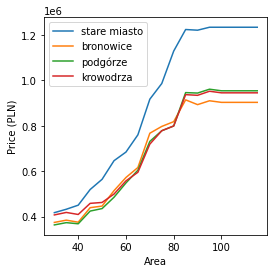

In [106]:
plt.figure()

for d in districts:
    value = list()
    for a in areas:
        pred = get_pred(district=d,
         seller='realtor',
         area=a,
         rooms=2,
         bathrooms=1,
         parking='street',
         garden=False,
         balcony=False,
         terrace=False,
         lift=False,
         new=True,
         estate=False,
         townhouse=True,
         apartment=False,
         land=False,
         studio=True)
        value.append(pred)
    plt.plot(areas, value, label=d)
    
plt.ylabel('Price (PLN)')
plt.xlabel('Area')
plt.legend(loc='best')
plt.savefig('img/area_vs_amount_by_district')
plt.show()

We do the same for different amounts of rooms.

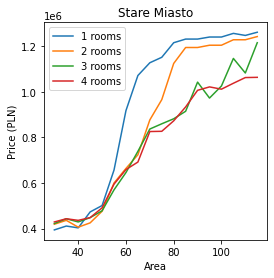

In [108]:
plt.figure()

for r in rooms:
    value = list()
    for a in areas:
        pred = get_pred(district='stare miasto',
         seller='owner',
         area=a,
         rooms=r,
         bathrooms=1,
         parking='street',
         garden=False,
         balcony=True,
         terrace=False,
         lift=False,
         new=True,
         estate=False,
         townhouse=True,
         apartment=False,
         land=False,
         studio=True)
        value.append(pred)
    plt.plot(areas, value, label=f'{r} rooms')
    
plt.title('Stare Miasto')
plt.ylabel('Price (PLN)')
plt.xlabel('Area')    
plt.legend(loc='best')
plt.savefig('img/area_vs_amount_by_rooms')
plt.show()

## Final training

The last step is to fit the model to the entire dataset and save it for later use.

In [103]:
mdl.fit(X, y)
model_path = ''
joblib.dump(mdl, f'../flats-model/model.joblib')

['../flats-model/model.joblib']